In [1]:
%matplotlib inline

import pandas as pd
import arrow
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
def encode_vals(col):
    items = list()
    for item in col.values:
        item = item[0]
        if isinstance(item, float): item = "None"
        if "Bear" in item: items.append(-1)
        elif "Bull" in item: items.append(1)
        else: items.append(0)
    return items

def encode_dates(col):
    items = list()
    for item in col.values:
        split = item[0].split("/")
        fill_2 = lambda x: x if len(x)==2 else "0"+str(x)
        item = "{}/{}/{}".format(fill_2(split[0]), fill_2(split[1]), split[2])
        items.append(arrow.get(item, 'MM/DD/YYYY'))
    return items

In [3]:
df = pd.read_csv("GartmanRecords2016.csv")[['Date', 'Stocks', 'Crude']]
df['Stocks'], df['Crude'] = map(encode_vals, [df[['Stocks']], df[['Crude']]])
df['Date'] = encode_dates(df[['Date']])
trades_table = df

In [4]:
data = pd.read_csv("HistoricalData.csv", names=['Date', 'Equities', 'Oil'])
data.drop(data.index[[0]], inplace=True) # delete header row
data['Equities'], data['Oil'] = pd.to_numeric(data['Equities'].values), pd.to_numeric(data['Oil'].values)
data['Date'] = encode_dates(data[['Date']])
data.set_index('Date', inplace=True)
data = data.T.to_dict("list")

In [14]:
matcher = {"equities": 0, "oil": 1}

class Trade(object):
    def __init__(self, enter_date, exit_date, name, shares):
        self.enter_date, self.exit_date = enter_date, exit_date
        self.name = name
        self.shares = shares
    
    def enter(self, cur_date):
        if cur_date == self.enter_date:
            self.initial_stock_value = data[self.enter_date][matcher[self.name]]
            self.inital_value = self.initial_stock_value * self.shares
            if self.shares > 0:
                print "Buying {} for {}".format(self.name, self.inital_value)
            else:
                print "Shorting {} for {}".format(self.name, self.inital_value)
            return 0
#             return self.inital_value
        else: return 0

    def exit(self, cur_date):
        if cur_date == self.exit_date:
            try: exit_stock_value = data[self.exit_date][matcher[self.name]]
            except KeyError: # no data for that day
                try: exit_stock_value = data[self.exit_date.replace(day=1)][matcher[self.name]]
                except KeyError: exit_stock_value = data[self.exit_date.replace(day=2)][matcher[self.name]]
            exit_value = exit_stock_value * self.shares
            self.profit = exit_value - self.inital_value
            if self.shares > 0:
                print "Selling {} for {} (profit {})".format(self.name, exit_value, self.profit)
            else:
                print "Covering {} for {} (profit {})".format(self.name, exit_value, self.profit)
            return self.profit
        else: return 0

In [23]:
EQ_SHARES = 10
OIL_SHARES = EQ_SHARES*100

def make_trades(trades):
    for trade_ in trades.iterrows():
        trade = trade_[1]
        if trade['Stocks'] != 0: name = "equities"; shares=EQ_SHARES*trade['Stocks']
        elif trade['Crude'] != 0: name = "oil"; shares = OIL_SHARES*trade['Crude']
        else: raise ValueError
            
        enter_date = trade['Date']
        exit_date = enter_date.replace(months=1)
        
        yield Trade(enter_date, exit_date, name, shares)
        
trades = list(make_trades(trades_table))

Shorting equities for -1988.2
Shorting oil for -9090.0
Buying oil for 8910.0
Covering equities for -1936.5 (profit 51.7)
Covering oil for -9020.0 (profit 70.0)
Shorting equities for -1947.8
Buying equities for 1950.9
Shorting equities for -1981.1
Buying equities for 1990.0
Selling oil for 9150.0 (profit 240.0)
Shorting equities for -2005.9
Shorting equities for -2033.4
Shorting equities for -2046.3
Shorting oil for -10480.0
Covering equities for -2045.6 (profit -97.8)
Selling equities for 1981.1 (profit 30.2)
Buying equities for 2055.2
Shorting equities for -2069.2
Covering equities for -2069.2 (profit -88.1)
Selling equities for 2069.2 (profit 79.2)
Covering equities for -2039.5 (profit -33.6)
Covering equities for -2069.2 (profit -35.8)
Covering equities for -2069.2 (profit -22.9)
Covering oil for -10170.0 (profit 310.0)
Buying oil for 11140.0
Selling equities for 2069.2 (profit 14.0)
Covering equities for -2079.7 (profit -10.5)
Shorting equities for -2058.9
Shorting equities for -20

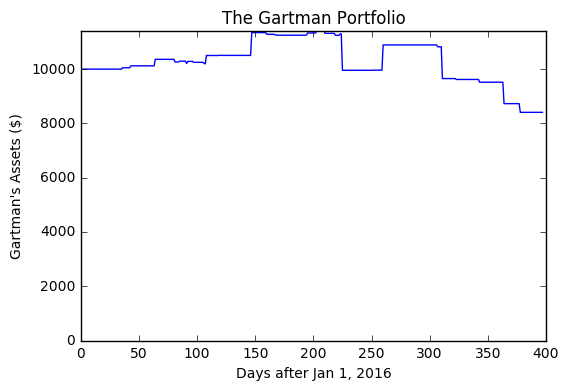

With Gartman's guidance, we went from $10000.00 to $8408.50!


In [25]:
initial_money = 10000
money = initial_money
portfolio = []

start = datetime(2016, 1, 1, 0, 0) # Jan 1, 2016
end = datetime(2017, 2, 1, 0, 0)   # Feb 1, 2017

for ind, date in enumerate(arrow.Arrow.range('day', start, end)):
    enters = [trade.enter(date) for trade in trades]
    profit = sum([trade.exit(date) for trade in trades])
    money += profit
    portfolio.append(money)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(portfolio)
ax.set_ylim(0, max(portfolio))
ax.set_title("The Gartman Portfolio")
ax.set_xlabel("Days after Jan 1, 2016")
ax.set_ylabel("Gartman's Assets ($)")
plt.show()
print "With Gartman's guidance, we went from ${:.2f} to ${:.2f}!".format(initial_money, money)